In [1]:
!pip3 install rpy2 torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
%matplotlib inline

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.16")

R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 Patched (2022-11-10
  r83330)

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 Patched (2022-11-10
  r83330)

R[write to console]: Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    boot, foreign, MASS, Matrix, spatial



In [6]:
%%R
BiocManager::install("splatter")

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 Patched (2022-11-10
  r83330)

R[write to console]: Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    boot, foreign, MASS, Matrix, spatial



In [7]:
%%R
# Load package
suppressPackageStartupMessages({
  library(splatter)
  library(scater)
})

## 1)Pre-processing
### 1.1) Simulate 5000 samples with 2000 genes from two cell types and load the samples in Torch tensors and provide a DataLoader.

In [8]:
%%R
sim <- splatSimulate(method="groups", nGenes = 2000, batchCells = 5000 , group.prob = c(0.5, 0.5), verbose=FALSE)

In [9]:
%%R
write.table(counts(sim), sep='\t', 'data.tsv')
write.table(colData(sim), sep='\t', 'labels.tsv')

In [22]:
import numpy as np
import pandas as pd
batch_size = 32
data = pd.read_csv('data.tsv', sep='\t').transpose()
labels = pd.read_csv('labels.tsv', sep='\t')

X = torch.tensor(data.values.astype(np.float32))
l = []
for y in list(labels["Group"]):
    if "Group1" in y:
        l.append(1)
    else:
        l.append(0)
y = torch.tensor(l)

train_dataset = torch.utils.data.TensorDataset(X, y) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

### 1.2) Normalized samples using z-score normalization and plot them beside raw samples

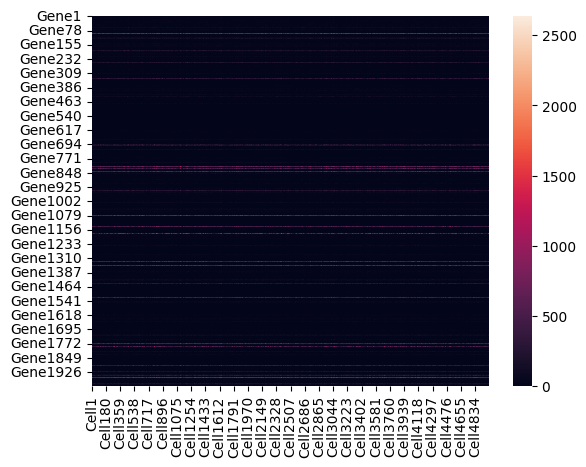

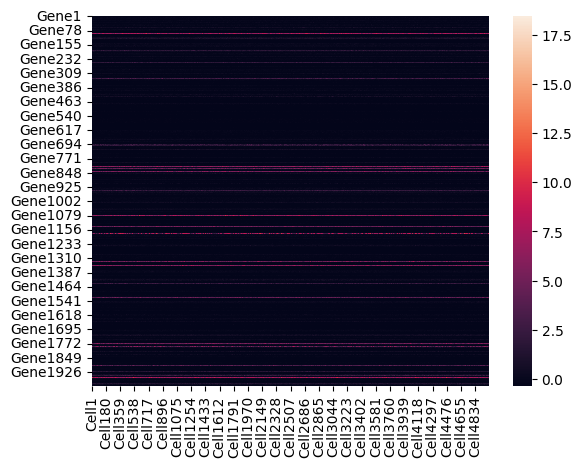

In [23]:
from scipy.stats import zscore
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
df=pd.read_csv('data.tsv', sep='\t')
df2=zscore(df)
ax = sns.heatmap(df)
plt.show()
ax2 = sns.heatmap(df2)
plt.show()

## 2) Train a MLP on the data to classify rna samples into one of the two cell types.
### 2.1) implement following MLP model in sequential fashion.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2000, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = x.view(-1, 2000)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

### 2.2) Instantiate (and name) the MLP model as `model`, Stochastic Gradient Descent optimizer as `optimizer` and Cross entropy loss as `criterion`. 


In [25]:
import torch
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

### 2.3) Fix the bug/s of the train method

In [31]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    i = 1
    for _ in range(epoch):
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            output = model(data)
            loss = criterion(output, target)
            if i%log_interval == 0:
                print(loss) 
            i += 1
            loss.backward()
            optimizer.step()

## 3) Evaluation
### 3.1) Change the previous codes to calculate test and train loss.

In [ ]:
train(100)

### 3.2) Change the previous codes to calculate Accuracy, specificity, sensitivity, and AUC for test set.